In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

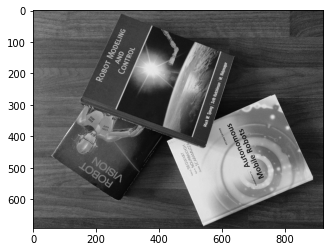

In [4]:
#############
### EX 10 ###
#############

img = cv2.imread('exam_data/Question_10/books.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray");

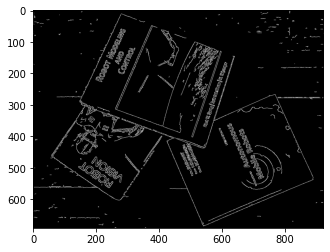

In [5]:
edges = cv2.Canny(gray, threshold1=100, threshold2=200)
plt.imshow(edges, cmap="gray");

In [6]:
lines = cv2.HoughLines(edges, rho=1, theta=0.0017, threshold=200)
for i in range(len(lines)):
    r = lines[i][0][0]
    theta = lines[i][0][1]
    
    x0 = r * np.cos(theta)
    y0 = r * np.sin(theta)
    
    pt1 = (int(x0 + 1000 * (-np.sin(theta))), int(y0 + 1000 * np.cos(theta)))
    pt2 = (int(x0 - 1000 * (-np.sin(theta))), int(y0 - 1000 * np.cos(theta)))
    
    cv2.line(img, pt1, pt2, (255, 0, 0), 3) 

no_lines 32


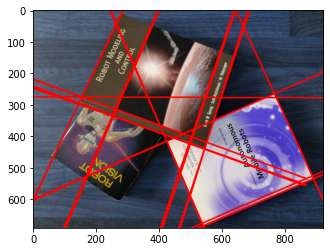

In [7]:
print("no_lines", len(lines))
plt.imshow(img, cmap="gray");

In [8]:
################
## Q11 Harris ##
################

img = cv2.imread('exam_data/Question_11/books.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
len(np.where(corners>0.01)[0])

188

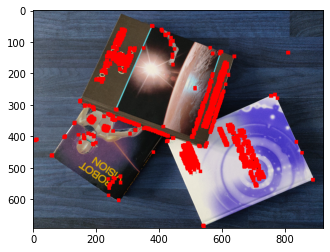

In [9]:
corners = cv2.dilate(corners, None, iterations=5)
img[corners > 0.01 * corners.max()]=[255, 0, 0]
plt.imshow(img);


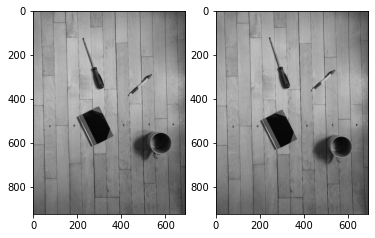

In [27]:
#################
## Q12 Optical ##
#################

img1 = cv2.imread('exam_data/Question_12/things1.png')
img2 = cv2.imread('exam_data/Question_12/things2.png')

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(gray1, cmap="gray")
axs[1].imshow(gray2, cmap="gray");


In [28]:
feat1 = cv2.goodFeaturesToTrack(gray1, maxCorners=100, qualityLevel=0.3, minDistance=7)
feat2, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, feat1, None)

Biggest shift in x direction (pixels) = 15.636841


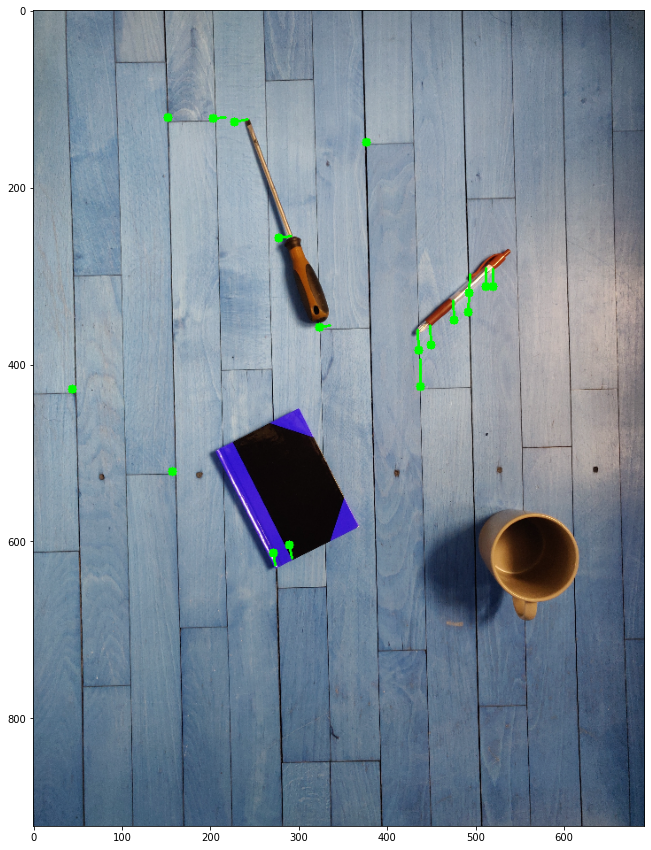

In [31]:
img = img2.copy()
max_shift = 0 # Max horizontal shift
for i in range(len(feat1)):
    
    f10=(feat1[i][0][0]) # x
    f11=(feat1[i][0][1]) # y
    f20=(feat2[i][0][0]) # x
    f21=(feat2[i][0][1]) # y
    x_shift = abs(f10-f20)
    if x_shift>max_shift:
        max_shift = x_shift
    if ((abs(f10-f20))/(f10+f20) >= 0.005) or ((abs(f11-f21))/(f11+f21) >= 0.005):
        cv2.line(img, (int(f10),int(f11)), (int(f20), int(f21)), (0, 255, 0), 2)
        cv2.circle(img, (int(f10), int(f11)), 5, (0, 255, 0), -1)
print("Biggest shift in x direction (pixels) =", max_shift)
plt.figure(figsize=(15,15))
plt.imshow(img);

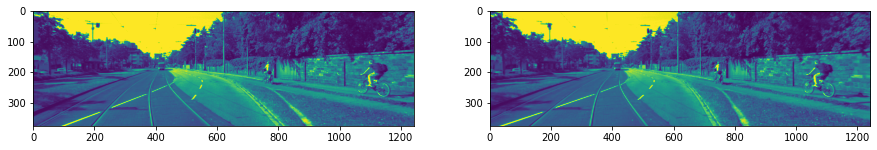

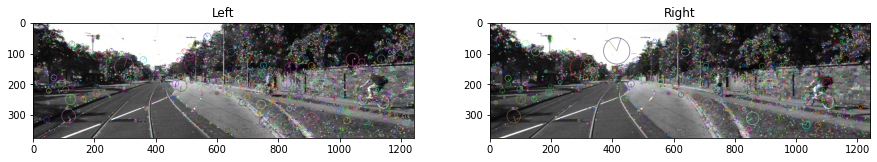

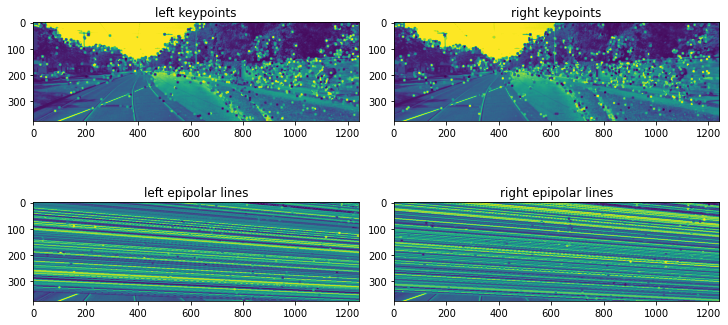

In [13]:
##############################
### Q18 Stereo Calibration ###
##############################

img1 = cv2.imread('exam_data/Question_18/left.png', 0)
img2 = cv2.imread('exam_data/Question_18/right.png', 0)
#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs[0].imshow(img1)
axs[1].imshow(img2);
img1.shape

# Create a sift detector
sift = cv2.xfeatures2d.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img_1 = cv2.drawKeypoints(img1, kp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_img_2 = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].imshow(kp_img_1)
ax[0].set_title('Left')
ax[1].imshow(kp_img_2)
ax[1].set_title('Right');
bf = cv2.BFMatcher()
matches = bf.match(des1, des2)
# 2000 best matches
matches = sorted(matches, key = lambda x:x.distance)[:2000]
#matches = matches[:2000]
# From exercise 2 week 4
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1, img2
# Extract points of matches
pts1 = []
pts2 = []

# Using 2000 best matches
for m in matches:
    # Extract points corresponding to matches.
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    
"""
Implement findFundamentalMat here:
"""
F, mask =cv2.findFundamentalMat(pts1, pts2, method=cv2.FM_RANSAC)

# We select only inlier points.
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1.copy(), img2.copy(), lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2.copy(), img1.copy(), lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,5))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()

In [14]:
w, h = lines1.shape
######### THE AVERAGE OF ALL EPILINES #########
print(sum(lines1)/w)
avg1 = sum(lines1)/w
print(sum(lines2)/w)
avg2 = sum(lines2)/w

[-6.69333264e-02  9.97691572e-01 -1.26727486e+02]
[ 7.0291542e-02 -9.9747336e-01  1.2541019e+02]


Possible answers:
```
[-6.69e-02  9.97e-01 -1.26e+02]
[ 7.02e-02 -9.97e-01  1.25e+02]
```
```
[-2.69e-02  3.97e-01 -0.06e+02]
[ 1.02e-02 -3.97e-01  0.05e+02]
```
```
[-11.69e-02  17.97e-01 -1.06e+02]
[ 11.02e-02 -17.97e-01  1.05e+02]
```
```
[-1.69e-02  7.97e-01 -0.26e+02]
[ 17.02e-02 -7.97e-01  0.25e+02]
```

In [35]:
###########
### Q23 ###
###########

from sklearn.cluster import KMeans, k_means
from sklearn.decomposition import PCA
import numpy as np

#######################################
# A  Elbow method Look for the elbow! #
#######################################
# Loading the data
X = np.loadtxt('exam_data/Question_23/clusters.txt', dtype=int)
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dists = []
for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(X)
    centers = km.cluster_centers_
    distortion = km.inertia_
    dists.append(distortion)

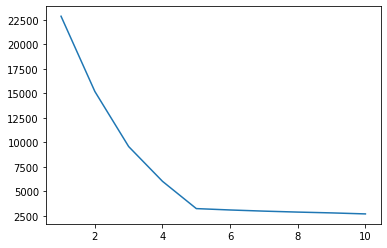

In [36]:
plt.plot(ks, dists);

In [37]:
#########
# B PCA #
#########

for i in [3, 4, 5, 6, 7]:
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(X)
    #print(pca.explained_variance_ratio_)
    print(i, sum(pca.explained_variance_ratio_))

3 0.8355700450336376
4 0.9158802934879949
5 0.9365634230676995
6 0.9547933422569365
7 0.9703028326788605


In [38]:
#########
# C All #
#########
X = np.loadtxt('exam_data/Question_23/clusters.txt', dtype=int)
# PCA
pca = PCA(n_components=6) # max
principalComponents = pca.fit_transform(X)
# Kmeans
km = KMeans(n_clusters=5)
km.fit(principalComponents)
centers = km.cluster_centers_
distortion = km.inertia_
print(distortion)

2192.118384651098


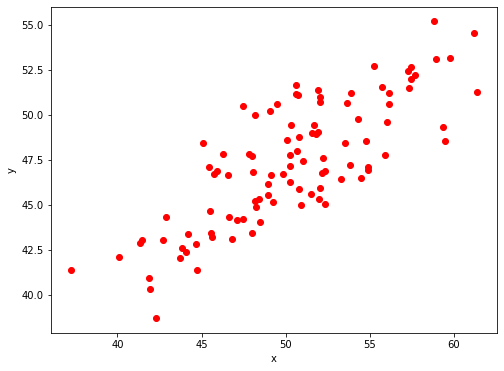

In [39]:
#############################
### Q24 Linear regression ### 
#############################

import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

x = np.loadtxt('exam_data/Question_24/lr_x.txt', dtype=float)
y = np.loadtxt('exam_data/Question_24/lr_y.txt', dtype=float)
plt.figure(figsize=(8, 6))
plt.plot(x, y, 'ro')   # scatter plot showing actual data
plt.xlabel('x')
plt.ylabel('y')
plt.show();

y = 0.545879376602731 x + 19.856337311955016


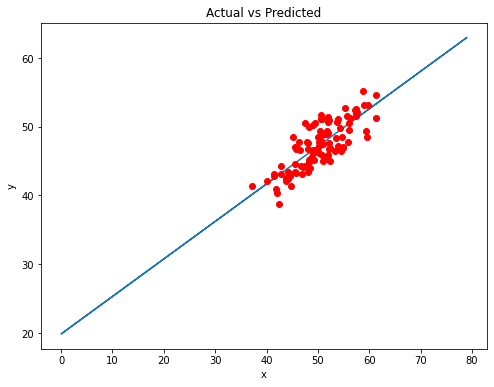

In [40]:
x_r = x.reshape(-1,1) #fit needs x in this shape
# Initialise and fit model
lm = LinearRegression()
model = lm.fit(x_r, y)
print("y =",model.coef_[0],"x +", model.intercept_)
#####################
new_x = np.random.randint(0,80, 200).reshape(-1,1)  
predicted = model.predict(new_x)
plt.figure(figsize=(8, 6))
plt.plot(new_x, predicted)     # regression line
plt.plot(x, y, 'ro')   # scatter plot showing actual data
plt.title('Actual vs Predicted')
plt.xlabel('x')
plt.ylabel('y')
plt.show();


In [41]:
###########################
### Q27 Kalman filter 1 ###
###########################
def update(x, P, Z, H, R):
    ### Insert update function
    y = Z - H@x
    s = H@P@H.T + R
    K = P@H.T@np.linalg.pinv(s)
    new_x = x + K@y
    new_P = (np.identity((K@H).shape[0]) - K@H)@P
    return new_x, new_P
    
def predict(x, P, F, u, Q):
    ### insert predict function
    new_x = F@x + u
    new_P = F@P@F.T + Q # Q=0. No internal disturbtion
    return new_x, new_P

# The initial state (4x1).
x = np.array([[3],      # Position along the x-axis
              [0.5],    # Velocity along the x-axis
              [2],      # Position along the y-axis 
              [0.33]])  # Velocity along the y-axis 

# The initial uncertainty (4x4).
P = np.array([[5, 1, 0, 0],
              [1, 2, 0, 0],
              [0, 0, 5, 1],
              [0, 0, 1, 2]])

# The external motion (4x1).
u = np.array([[0],
              [0],
              [0],
              [0]])

# The transition matrix (4x4). 
# Constant velocity model.
F = np.array([[1, 1, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 1],
              [0, 0, 0, 1]])

# Disturbance matrix
# No model disturbance
Q = np.array([[0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0]])

next_x, next_P = predict(x, P, F, u, Q)
next_x, next_P

(array([[3.5 ],
        [0.5 ],
        [2.33],
        [0.33]]),
 array([[9, 3, 0, 0],
        [3, 2, 0, 0],
        [0, 0, 9, 3],
        [0, 0, 3, 2]]))

In [42]:
###########################
### Q28 Kalman filter 2 ###
###########################
def update(x, P, Z, H, R):
    ### Insert update function
    y = Z - H@x
    s = H@P@H.T + R
    K = P@H.T@np.linalg.pinv(s)
    new_x = x + K@y
    new_P = (np.identity((K@H).shape[0]) - K@H)@P
    return new_x, new_P
    
def predict(x, P, F, u, Q):
    ### insert predict function
    new_x = F@x + u
    new_P = F@P@F.T + Q # Q=0. No internal disturbtion
    return new_x, new_P

# The initial state (4x1).
x = np.array([[5],      # Position along the x-axis
              [0.5],    # Velocity along the x-axis
              [7],      # Position along the y-axis 
              [0.8]])  # Velocity along the y-axis 

# The initial uncertainty (4x4).
P = np.array([[0.2, 0  , 0  , 0  ],
              [0.2, 0.1, 0  , 0  ],
              [0  , 0  , 0.2, 0  ],
              [0  , 0  , 0.2, 0.1]])

# The observation matrix (2x4).
H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

# The measurement uncertainty.
# How little do you want to trust the measurements?
R = np.array([[0.2, 0.2],
              [0.2, 0.2]])

# measurements
z = np.array([[4.8],
              [7.1]])


next_x, next_P = update(x, P, z, H, R)
next_x

array([[4.83333333],
       [0.33333333],
       [7.13333333],
       [0.93333333]])

In [43]:
###############
### Q29 SVM ###
###############
 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import svm
from sklearn import metrics
x = np.loadtxt('exam_data/Question_29/svm_x.txt', dtype=float)
y = np.loadtxt('exam_data/Question_29/svm_y.txt', dtype=int)

In [44]:
# Split validation data out: 70% for training
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1337)

In [47]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9590643274853801


In [46]:
###############
### Q32 SVM ###
###############



# Seperate script